# notes

## projections

- 4326 # wgs84 (for H3 compatibility)
    - H3 **does not use** wgs84/epsg4326, but it **does use** the "authalic radius" from that standard
    - lat/lng
- 3857 # web mercator (for plotting), but in meters!
- 2263 # new york (just what's used in the example below)

## geoviews

- tile options: https://github.com/holoviz/geoviews/blob/main/geoviews/tile_sources.py
    - also this, but i don't see a good way to programatically get all the options: https://geoviews.org/gallery/matplotlib/tile_sources.html 
- active tools: https://stackoverflow.com/questions/57767169/set-box-zoom-or-pan-or-wheel-zoom-as-default-in-using-holoviews-or-hvplot
- bokeh pallets: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
- Bokeh "tap" tool seems to do something on this website, but i can't get the same functionality (isolating a single geometry) locally: https://geoviews.org/gallery/bokeh/new_york_boroughs.html

## folium

- seems to be most popular, but they make you manually determine the center and zoom level!
    - too much work. geoviews does it automatically
    - https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html

In [1]:
import h3
import geopandas
import geodatasets
import contextily as cx
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
cells = ['8428309ffffffff', '842830dffffffff']
h3.cells_to_h3shape(cells, tight=False)

<H3MultiPoly: [10]>

In [2]:
df = geopandas.read_file(geodatasets.get_path('nybb'))
df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [3]:
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [4]:
def foo(df, epsg):
    df = df.to_crs(epsg=epsg)
    
    ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column='BoroName', categorical=True, legend=True, legend_kwds={'loc': 'upper left'})
    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    cx.add_basemap(ax, crs=df.crs, source=cx.providers.CartoDB.Positron)

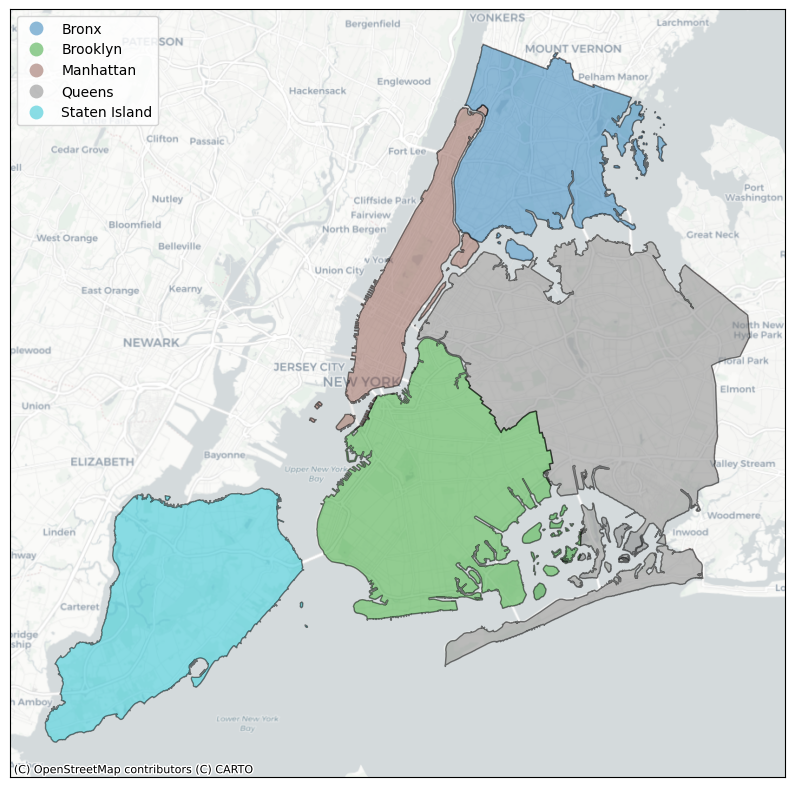

In [5]:
foo(df, 2263)

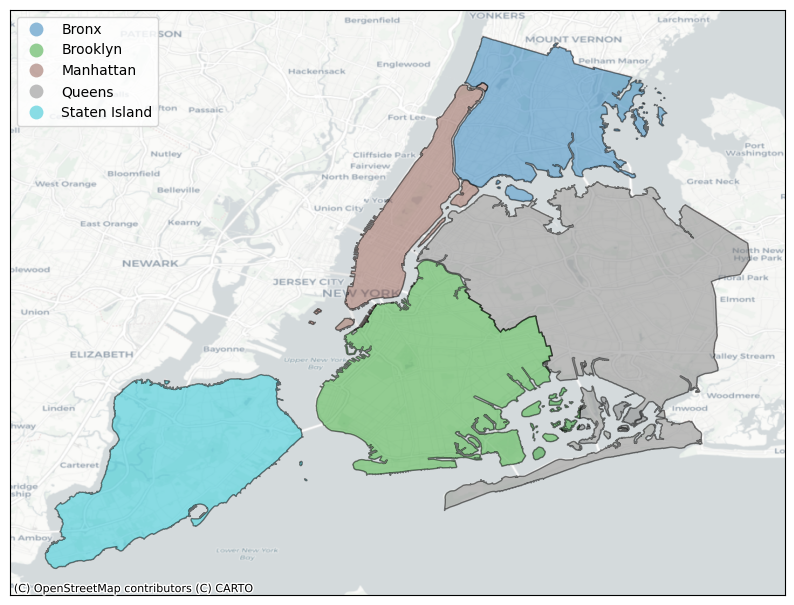

In [6]:
foo(df, 4326)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
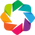

In [7]:
import geodatasets as gds
import geopandas as gpd
import geoviews as gv
import cartopy.crs as ccrs

gv.extension('bokeh');

In [8]:
def bar(df, epsg):
    crs = ccrs.epsg(epsg)
    df = df.to_crs(crs)
    
    tiles = gv.tile_sources.CartoLight
    polys = gv.Polygons(df, vdims=['BoroName'], crs=df.crs)

    out = tiles * polys.opts(color='BoroName', cmap='Pastel1', tools=['hover'], width=1200, height=800, alpha=0.5, active_tools=['wheel_zoom'], xaxis=None, yaxis=None)

    return out

In [9]:
bar(df, 3857)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (BoroName)

# converting to cells

In [10]:
df = geopandas.read_file(geodatasets.get_path('nybb'))
df = df[['BoroName', 'geometry']]
df = df.to_crs(epsg=4326)
df

,BoroName,geometry
0,Staten Island,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,Queens,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,Brooklyn,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,Manhattan,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,Bronx,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


In [11]:
res = 9
df.geometry.apply(lambda x: h3.geo_to_cells(x, res=res)).apply(h3.cells_to_h3shape)

0                      <H3MultiPoly: [368], [20], [6]>
1    <H3MultiPoly: [632/(6, 6, 6, 6, 6)], [290/(6,)...
2    <H3MultiPoly: [490/(6, 6, 10, 10, 14, 10, 6)],...
3    <H3MultiPoly: [344/(6,)], [22], [6], [10], [6]...
4    <H3MultiPoly: [382/(18, 6, 6)], [32], [6], [18...
dtype: object

In [13]:
res = 9
df.geometry.apply(lambda x: h3.geo_to_cells(x, res=res)).apply(h3.cells_to_h3shape)[1]

<H3MultiPoly: [632/(6, 6, 6, 6, 6)], [290/(6,)], [120], [12], [10], [10]>

<H3MultiPoly: [10]>

In [61]:
res = 9

df2 = df.copy()
df2.geometry = df.geometry.apply(lambda x: h3.geo_to_cells(x, res=res)).apply(h3.compact_cells).apply(lambda x: h3.H3MultiPoly(*[h3.cells_to_h3shape({y})[0] for y in x]))
df2.BoroName = df2.BoroName + ' H3'

In [62]:
df2

,BoroName,geometry
0,Staten Island H3,"MULTIPOLYGON (((-74.23342 40.54401, -74.22901 ..."
1,Queens H3,"MULTIPOLYGON (((-73.84066 40.76257, -73.84060 ..."
2,Brooklyn H3,"MULTIPOLYGON (((-73.92189 40.70318, -73.91973 ..."
3,Manhattan H3,"MULTIPOLYGON (((-73.93648 40.86148, -73.93430 ..."
4,Bronx H3,"MULTIPOLYGON (((-73.82025 40.85039, -73.82018 ..."


In [63]:
df3 = pd.concat([df, df2])

In [64]:
bar(df2, 3857)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (BoroName)

In [16]:
# TODO: this needs to show H3MultiPoly
df['geometry_h3_9'] = df.geometry.apply(lambda x: h3.geo_to_cells(x, 9)).apply(lambda x: h3.cells_to_h3shape(x))
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,geometry_h3_9
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...","(<H3Poly: [368]>, <H3Poly: [20]>, <H3Poly: [6]>)"
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...","(<H3Poly: [632/(6, 6, 6, 6, 6)]>, <H3Poly: [29..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...","(<H3Poly: [490/(6, 6, 10, 10, 14, 10, 6)]>, <H..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...","(<H3Poly: [344/(6,)]>, <H3Poly: [22]>, <H3Poly..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...","(<H3Poly: [382/(18, 6, 6)]>, <H3Poly: [32]>, <..."


In [18]:
df.geometry = df.geometry_h3_9

In [19]:
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,geometry_h3_9
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.18870 40.64296, -74.19079 ...","(<H3Poly: [368]>, <H3Poly: [20]>, <H3Poly: [6]>)"
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.78640 40.61868, -73.78430 ...","(<H3Poly: [632/(6, 6, 6, 6, 6)]>, <H3Poly: [29..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.89758 40.62460, -73.89542 ...","(<H3Poly: [490/(6, 6, 10, 10, 14, 10, 6)]>, <H..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-73.92121 40.79837, -73.92128 ...","(<H3Poly: [344/(6,)]>, <H3Poly: [22]>, <H3Poly..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.82954 40.81046, -73.82743 ...","(<H3Poly: [382/(18, 6, 6)]>, <H3Poly: [32]>, <..."


In [ ]:
crs = ccrs.epsg(3857)
df = df.to_crs(crs)

tiles = gv.tile_sources.CartoLight
polys = gv.Polygons(df, vdims=['BoroName'], crs=df.crs)

out = tiles * polys.opts(color='BoroName', cmap='Pastel1', tools=['hover'], width=1200, height=800, alpha=0.5, active_tools=['wheel_zoom'], xaxis=None, yaxis=None)

return out

In [20]:
bar(df, 3857)

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (BoroName)

old version:

`H3MultiPoly(<H3Poly[368]>, <H3Poly[20]>, <H3Poly[6]>)`

new version:

`<H3MultiPoly([368], [20], [6])>`

In [17]:
import pandas as pd

pd.DataFrame(out)

,0
0,"(<H3Poly: [368]>, <H3Poly: [20]>, <H3Poly: [6]>)"
1,"(<H3Poly: [632/(6, 6, 6, 6, 6)]>, <H3Poly: [29..."
2,"(<H3Poly: [490/(6, 6, 10, 10, 14, 10, 6)]>, <H..."
3,"(<H3Poly: [344/(6,)]>, <H3Poly: [22]>, <H3Poly..."
4,"(<H3Poly: [382/(18, 6, 6)]>, <H3Poly: [32]>, <..."


In [18]:
for a in out:
    print(a)

<H3MultiPoly: [368], [20], [6]>
<H3MultiPoly: [632/(6, 6, 6, 6, 6)], [290/(6,)], [120], [12], [10], [10]>
<H3MultiPoly: [490/(6, 6, 10, 10, 14, 10, 6)], [18], [6], [6], [6], [6], [10], [16], [26], [6], [14], [6]>
<H3MultiPoly: [344/(6,)], [22], [6], [10], [6], [6]>
<H3MultiPoly: [382/(18, 6, 6)], [32], [6], [18], [6], [28]>


In [19]:
"<H3Poly: [368]>"

'<H3Poly: [368]>'

In [20]:
out = df84.geometry.apply(lambda x: h3.geo_to_cells(x, 9)).apply(lambda x: h3.cells_to_h3shape(x))
out

for a in out:
    out = [p.loopcode for p in a]
    out = ', '.join(out)
    out = f'<H3MultiPoly: {out}>'
    print(out)

<H3MultiPoly: [368], [20], [6]>
<H3MultiPoly: [632/(6, 6, 6, 6, 6)], [290/(6,)], [120], [12], [10], [10]>
<H3MultiPoly: [490/(6, 6, 10, 10, 14, 10, 6)], [18], [6], [6], [6], [6], [10], [16], [26], [6], [14], [6]>
<H3MultiPoly: [344/(6,)], [22], [6], [10], [6], [6]>
<H3MultiPoly: [382/(18, 6, 6)], [32], [6], [18], [6], [28]>


In [21]:
out = df84.geometry.apply(lambda x: h3.geo_to_cells(x, 9)).apply(lambda x: h3.cells_to_h3shape(x))
out

for a in out:
    out = [p.loopcode for p in a]
    out = ', '.join(out)
    out = f'<H3MultiPoly: {out}>'
    print(out)

<H3MultiPoly: [368], [20], [6]>
<H3MultiPoly: [632/(6, 6, 6, 6, 6)], [290/(6,)], [120], [12], [10], [10]>
<H3MultiPoly: [490/(6, 6, 10, 10, 14, 10, 6)], [18], [6], [6], [6], [6], [10], [16], [26], [6], [14], [6]>
<H3MultiPoly: [344/(6,)], [22], [6], [10], [6], [6]>
<H3MultiPoly: [382/(18, 6, 6)], [32], [6], [18], [6], [28]>


In [22]:
def shortcode(poly):
    outer = len(poly.outer)
    holes = tuple(map(len, poly.holes))

    outer = str(outer)

    if holes:
        out = outer + '/' + str(holes)
    else:
        out = outer

    return out

In [23]:
def my_repr(h3poly):
    polys = [
        str(len(p.outer)) + '/'+ str(tuple(map(len, p.holes)))
        for p in h3poly
    ]
    return 'H3MultiPoly:' + str(polys)

for a in out:
    print(my_repr(a))

AttributeError: 'str' object has no attribute 'outer'

In [ ]:
def my_repr(h3poly):
    polys = [
        shortcode(p)
        for p in h3poly
    ]
    return 'H3MultiPoly:' + str(polys)

for a in out:
    print(my_repr(a))

In [ ]:
def my_repr(h3poly):
    polys = [
        shortcode(p)
        for p in h3poly
    ]
    return 'H3MultiPoly: ' + ', '.join(polys)

for a in out:
    print(my_repr(a))

In [ ]:
def my_repr(h3poly):
    polys = [
        str(len(p.outer)) + '/'+ str(tuple(map(len, p.holes)))
        for p in h3poly
    ]
    return 'H3MultiPoly: ' + ', '.join(polys)

for a in out:
    print(my_repr(a))

In [ ]:
def my_repr(h3poly):
    polys = [
        str(len(p.outer)) + '-'+ str(tuple(map(len, p.holes)))
        for p in h3poly
    ]
    return 'H3MultiPoly: ' + ', '.join(polys)

for a in out:
    print(my_repr(a))

In [ ]:
def my_repr(h3poly):
    polys = [
        '['+shortcode(p)+']'
        for p in h3poly
    ]
    return 'H3MultiPoly: ' + ', '.join(polys)

for a in out:
    print(my_repr(a))

In [ ]:
def my_repr(h3poly):
    polys = [
        shortcode(p)
        for p in h3poly
    ]
    return 'H3MultiPoly: ' + ', '.join(polys)

for a in out:
    print(my_repr(a))

In [ ]:
# todo: make this the polygon shortcode representation! people will learn fast. make it well-documented. it'll be fine
# example question

"""
Q: what do codes of the form `[n/(x,y,z)]` mean?
A: a polygon with an outer ring of n unique vertices, and 3 holes with x,y,and z unique vertices, respectively.
"""

